In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colors as c
import seaborn
import json
import time
import statistics

In [2]:
# For Nerual Network
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, InputLayer, Dense

from keras.utils import np_utils

# Naive Bayes Classifier

### Training Functions

In [3]:
def get_probability_of_face_labels(training_face_data_df):
    # Get the count of each label
    len_of_face_training = len(training_face_data_df)
    counter_of_face_labels = Counter(training_face_data_df['Label'].to_numpy())
    # Get the probability of each label
    probability_of_face_labels = {}
    for i in counter_of_face_labels.keys():
        probability_of_face_labels[i] = counter_of_face_labels[i]/len_of_face_training
    return probability_of_face_labels, counter_of_face_labels
    # Image size = 70 x 60

In [4]:
def get_probability_of_face_features(training_face_data_df, counter_of_face_labels):
    # Used to store the probability of each grid
    dict_of_face_g = {}
    # Get the number of features from the data
    no_of_face_features = len(training_face_data_df.iloc[0])-2

    # We split the G values based on the labels
    for i in range(no_of_face_features):
        dict_of_face_g['G'+str(i)] = np.split(training_face_data_df['G'+str(i)].to_numpy(), [counter_of_face_labels[0]])

    # Get the probability of each feature
    probability_of_face_features = {}
    cnt = 0
    for i in range(no_of_face_features):
        temp = {}
        for j in range(2):
            temp[j] = dict(Counter(dict_of_face_g['G'+str(i)][j]))
            # Since each grid is of size 6x7 so there are 42 pixels and 43 combinations
            for k in range(43):
                cnt+=1
                if(k not in temp[j]):
                    temp[j][k] = 10**-3
                else:
                    temp[j][k] /= counter_of_face_labels[j]
        probability_of_face_features['G'+str(i)] = temp
    return probability_of_face_features, no_of_face_features
    # Probability of features levels
    # [Grid_number][Label][No. of Black pixels]

### Testing Functions

In [23]:
def perform_face_testing(testing_face_data_df, probability_of_face_features, prob_of_face_labels):
    # Keep track of correct predictions
    true_cases = 0

    confusion_matrix_values = np.zeros((2,2))
    
    len_of_face_testing = len(testing_face_data_df)
    testing_labels = testing_face_data_df['Label'].to_numpy()
    
    # Iterate over the testing data
    for i in range(len_of_face_testing):
        current_test_data = testing_face_data_df.iloc[i]
        # Contains the probability of each feature for the given data point
        dict_of_final_probabilities = {}
        for l in range(2):
            temp_prod = 1
            for g in range(100):
                temp_prod *= probability_of_face_features['G'+str(g)][l][current_test_data['G'+str(g)]]
            dict_of_final_probabilities[l] = temp_prod*prob_of_face_labels[l]
        # True prediction
        if(testing_labels[i] == max(dict_of_final_probabilities, key=dict_of_final_probabilities.get)):
            true_cases+=1
            confusion_matrix_values[testing_labels[i]][testing_labels[i]]+=1
        # False prediction
        else:
            confusion_matrix_values[testing_labels[i]][max(dict_of_final_probabilities, key=dict_of_final_probabilities.get)] += 1
    accuracy = true_cases*100/len_of_face_testing
    return accuracy, confusion_matrix_values
    

In [24]:
def random_naive_face_test(test_face_df, probability_of_face_features, probability_of_face_labels):
    current_df = test_face_df.iloc[0]
    label = current_df['Label']
    dict_of_final_probabilities = {}
    no_of_features = len(test_face_df.iloc[0])-2
    for l in range(2):
        temp_prod = 1
        for g in range(no_of_features):
            temp_prod *= probability_of_face_features['G'+str(g)][l][current_df['G'+str(g)]]
        dict_of_final_probabilities[l] = temp_prod*probability_of_face_labels[l]
    return max(dict_of_final_probabilities, key=dict_of_final_probabilities.get), label

### Testing after training on entire dataset

In [7]:
# Get the data
training_face_data_df = pd.read_csv('./data/facedata/facetrainwithfeatures.csv')
training_face_data_df = pd.concat([training_face_data_df, pd.read_csv('./data/facedata/facevalidationwithfeatures.csv')])
testing_face_data_df = pd.read_csv('./data/facedata/facetestwithfeatures.csv')


In [25]:
# Training on entire data
training_face_data_df = training_face_data_df.sort_values('Label')
start_time = time.time()
probability_of_face_labels, counter_of_face_labels = get_probability_of_face_labels(training_face_data_df)
probability_of_face_features, no_of_face_fetures = get_probability_of_face_features(training_face_data_df, counter_of_face_labels)
print("Training time :", time.time()-start_time,'s')
accuracy, confusion_matrix_values = perform_face_testing(testing_face_data_df, probability_of_face_features, probability_of_face_labels)


Training time : 0.015506744384765625 s


Accuracy: 97.33333333333333


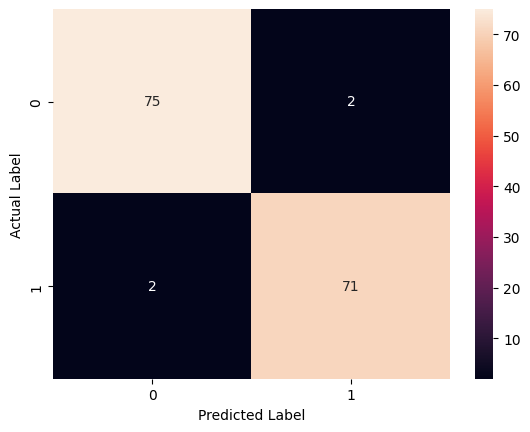

In [26]:
print("Accuracy:",accuracy)
# Generate confusion matrix
dataframe_confusion_matrix = pd.DataFrame(confusion_matrix_values, range(2), range(2))
heatmap = seaborn.heatmap(dataframe_confusion_matrix, annot=True, fmt='g')
heatmap.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()

### Training on subdivisions of dataset

In [63]:
mean_list = []
# The two std lists will show how much do the values deviate from the mean in our samples
std_low = []
std_low = []
std_high = []
time_list = []
no_of_datapoints = []
# Iterate over different sample size
for perc in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    accuracy_list = []
    temp_times = []
    # 5 random dataset
    for s in range(5):
        sample_training_df = training_face_data_df.sample(frac=perc, random_state=s)
        sample_training_df  = sample_training_df.sort_values('Label')
        start_time = time.time()
        probability_of_labels, counter_of_labels = get_probability_of_face_labels(sample_training_df)
        probability_of_features, no_of_features = get_probability_of_face_features(sample_training_df, counter_of_labels)
        temp_times.append(time.time() - start_time)
        accuracy, confusion_matrix_values = perform_face_testing(testing_face_data_df, probability_of_features, probability_of_labels)
        accuracy_list.append(accuracy)
    no_of_datapoints.append(len(sample_training_df))
    time_list.append(statistics.mean(temp_times))
    mean = statistics.mean(accuracy_list)
    mean_list.append(mean)
    std_dev = statistics.stdev(accuracy_list)
    std_low.append(mean-std_dev)
    std_high.append(mean+std_dev)


In [64]:
print("Mean Values:", mean_list)
print("Size of Training data", no_of_datapoints)

Mean Values: [82.39999999999999, 90.0, 92.53333333333333, 93.86666666666666, 95.73333333333333, 96.26666666666667, 96.8, 97.46666666666667, 97.6, 97.33333333333333]
Size of Training data [75, 150, 226, 301, 376, 451, 526, 602, 677, 752]


### Plotting Results

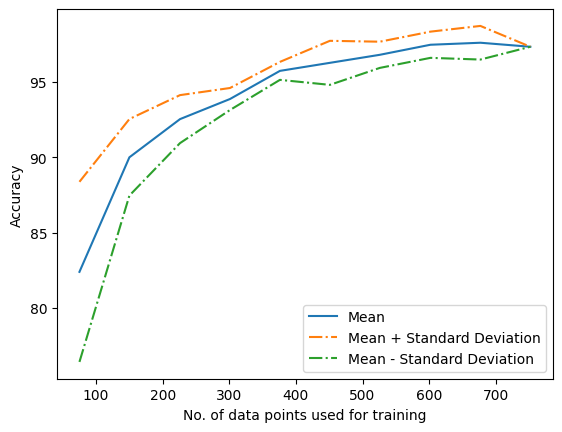

In [65]:
# Plot the graph of mean and standard deviation
plt.plot(no_of_datapoints, mean_list, label="Mean")
plt.plot(no_of_datapoints, std_high,'-.' ,label="Mean + Standard Deviation")
plt.plot(no_of_datapoints, std_low,'-.',label="Mean - Standard Deviation")
plt.xlabel("No. of data points used for training")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

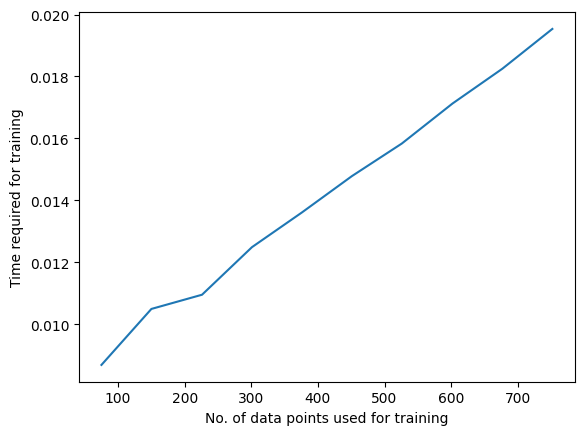

In [66]:
plt.plot(no_of_datapoints, time_list)
plt.xlabel("No. of data points used for training")
plt.ylabel("Time required for training")
plt.show()

# Perceptron

In [10]:
filepath = './data'

In [11]:
train_df = pd.read_csv(filepath+"/facedata/facetrainwithfeatures.csv", index_col=False)
train_df['Image_data'] = train_df['Image_data'].apply(json.loads)

In [12]:
validation_df = pd.read_csv(filepath+"/facedata/facevalidationwithfeatures.csv", index_col=False)
validation_df['Image_data'] = validation_df['Image_data'].apply(json.loads)

In [13]:
test_df = pd.read_csv(filepath+"/facedata/facetestwithfeatures.csv", index_col=False)
test_df['Image_data'] = test_df['Image_data'].apply(json.loads)

In [14]:
train_valid_df = train_df.append( validation_df , ignore_index = True )

### Training Functions

In [15]:
def initialize_weights(cols, rows):
  return [0 for i in range(cols*rows+1)]

In [27]:
def f(data,w):
  x = list( np.array(data).flat )
  return np.dot(x,w[1:])+w[0]

In [28]:
def update(data,w,sign):
  x = list( np.array(data).flat )
  w[0] = w[0] + (sign * 1)
  for i in range( len(x) ):
    w[i+1] = w[i+1] + (sign * x[i])

In [29]:
def predict_value(input,weight):
  if(f(input,weight)>=0):
    return 1
  else:
    return 0

In [30]:
def train_perceptron(df,weight):
  start_time = time.time()
  change=1
  itr = 0
  while(change!=0 and itr<1000 ):
    change=0
    for row in df.itertuples():
      data = row[1]
      label = row[2]
      fx = f(data,weight)
      if( (fx>=0 and label==1) or (fx<0 and label==0) ):
        pass
      elif(fx<0):
        update(data,weight,1)
        change += 1
      else:
        update(data,weight,-1)
        change += 1
    itr += 1
  time_taken = time.time()-start_time
  print("Training Completed in",itr,"Iterations")
  print("Time Taken : ",time_taken)
  return time_taken

In [31]:
def display_image(data):
    cMap = c.ListedColormap( ['black', 'white'] )
    plot = plt.pcolormesh(data, cmap=cMap)
    plot.axes.set_aspect('equal')  
    plt.xticks([])  
    plt.yticks([])  
    plot.axes.invert_yaxis()
    plt.show()

In [32]:
def accuracy(df,weight):
  count = 0
  for row in df.itertuples():
    ans = predict_value( row[1] ,weight)
    if(ans == row[2]):
      count +=1
  return count/len(df)

In [33]:
def perceptron_accuracy(train,test):
  weight = initialize_weights(60,70)
  Time = train_perceptron(train,weight)
  return accuracy(test,weight),Time

### Training on entire dataset

In [19]:
weight = initialize_weights(60,70)
time_taken = train_perceptron(train_valid_df,weight)

Training Completed in 7 Iterations
Time Taken :  4.558201313018799


### Testing Functions

In [34]:
def performance(weight,df):
  count=0
  confusion_matrix_values = np.zeros((2,2))
  for row in df.itertuples():
    ans = predict_value( row[1] ,weight)
    if(ans == row[2]):
      count +=1
    confusion_matrix_values[row[2]][ans]+=1
  
  print("Accuracy",count/len(df))

  dataframe_confusion_matrix = pd.DataFrame(confusion_matrix_values, range(2), range(2))
  heatmap = seaborn.heatmap(dataframe_confusion_matrix, annot=True, fmt='g')
  heatmap.set(xlabel='Predicted Values', ylabel='Actual Values')

In [21]:
weights_df = pd.read_csv(filepath+"/weights/faceweightsnew.csv", index_col=False)
weights_df['Weights'] = weights_df['Weights'].apply(json.loads)
weights = weights_df['Weights'].tolist()
weight = weights[0]

Accuracy 0.8933333333333333


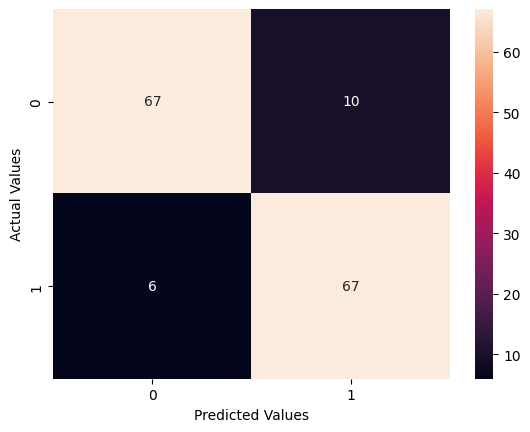

In [35]:
performance(weight,test_df)

In [36]:
def random_perceptron_face_test(test_face_df, weight):
    current_df = test_face_df.iloc[0]
    ans = predict_value( current_df['Image_data'] ,weight)
    label = current_df['Label']
    return ans, label


### Saving weights

In [18]:
weights_df = pd.DataFrame(columns = ['Weights'])

weights_df['Weights']=[weight]
weights_df

,Weights
0,"[[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
weights_df.to_csv(filepath+"/facedata/faceweightsnew.csv", index=False)

### Training on subdivisions of dataset

In [ ]:
Mean = []
Std = []
Time = []
for i in range(1,11):
  train_size = round(0.1 * i,1)
  print("Train Size :",train_size)
  print()
  acc = []
  time_list = []
  for i in range(5):
    temp,temp_time = perceptron_accuracy(train_valid_df.sample(frac = train_size, random_state = i), test_df )
    print("Accuracy : ",temp)
    acc.append(temp)
    time_list.append(temp_time)
    print()
  print("Mean : ",np.mean(acc) )
  print("Std  : ",np.std(acc,ddof=1))
  print("Time : ",np.mean(time_list))
  Mean.append(np.mean(acc))
  Std.append(np.std(acc,ddof=1))
  Time.append(np.mean(time_list))
  print("---------------------------------------------------------------------------------------------\n")

Train Size : 0.1

Training Completed in 4 Iterations
Time Taken :  0.4205601215362549
Accuracy :  0.7066666666666667

Training Completed in 5 Iterations
Time Taken :  0.530848503112793
Accuracy :  0.7733333333333333

Training Completed in 7 Iterations
Time Taken :  0.6672475337982178
Accuracy :  0.82

Training Completed in 5 Iterations
Time Taken :  0.4896352291107178
Accuracy :  0.8

Training Completed in 7 Iterations
Time Taken :  0.6537606716156006
Accuracy :  0.7933333333333333

Mean :  0.7786666666666666
Std  :  0.04356349134054544
Time :  0.5524104118347168
---------------------------------------------------------------------------------------------

Train Size : 0.2

Training Completed in 6 Iterations
Time Taken :  1.0676140785217285
Accuracy :  0.82

Training Completed in 6 Iterations
Time Taken :  1.0671494007110596
Accuracy :  0.8533333333333334

Training Completed in 5 Iterations
Time Taken :  0.9409856796264648
Accuracy :  0.8333333333333334

Training Completed in 7 Iterati

In [32]:
print("Mean = ",Mean)
print("Std  = ",Std)
print("Time = ",Time)


Mean =  [0.7786666666666666, 0.8306666666666667, 0.8480000000000001, 0.86, 0.8786666666666667, 0.8720000000000001, 0.876, 0.884, 0.892, 0.8880000000000001]
Std  =  [0.04356349134054544, 0.018012341448141757, 0.022803508501982785, 0.028674417556808746, 0.014452988925785872, 0.01849924923401547, 0.03003701420285017, 0.012110601416389987, 0.008692269873603532, 0.023285665595430643]
Time =  [0.5524104118347168, 1.1132045269012452, 1.4870735645294189, 1.9461733818054199, 2.919754886627197, 3.1235379695892336, 3.8988749504089357, 4.656020736694336, 5.145175838470459, 6.574578285217285]


### Plotting results

In [4]:
# Final output after training over all subdivisions
Mean =  [0.7786666666666666, 0.8306666666666667, 0.8480000000000001, 0.86, 0.8786666666666667, 0.8720000000000001, 0.876, 0.884, 0.892, 0.8880000000000001]
Std  =  [0.04356349134054544, 0.018012341448141757, 0.022803508501982785, 0.028674417556808746, 0.014452988925785872, 0.01849924923401547, 0.03003701420285017, 0.012110601416389987, 0.008692269873603532, 0.023285665595430643]
Time =  [0.5524104118347168, 1.1132045269012452, 1.4870735645294189, 1.9461733818054199, 2.919754886627197, 3.1235379695892336, 3.8988749504089357, 4.656020736694336, 5.145175838470459, 6.574578285217285]

In [5]:
high = list(np.array(Mean) + np.array(Std))
low = list(np.array(Mean) - np.array(Std))

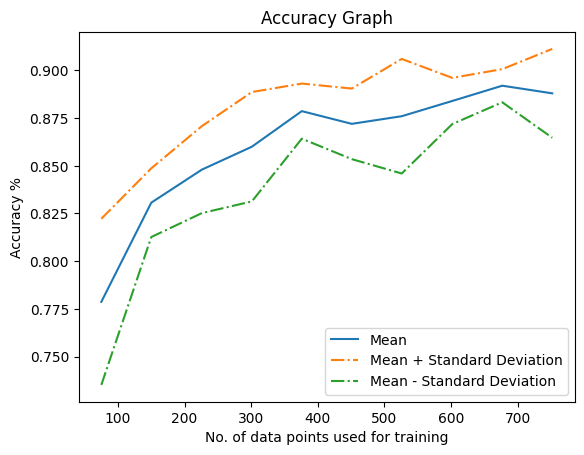

In [6]:
x = [round(75.2*i) for i in range(1,11)]
plt.plot(x, Mean, label="Mean")
plt.plot(x, high,'-.', label="Mean + Standard Deviation")
plt.plot(x, low, '-.', label="Mean - Standard Deviation")
plt.ylabel('Accuracy %')
plt.xlabel('No. of data points used for training')
plt.title("Accuracy Graph")
plt.legend()
plt.show()


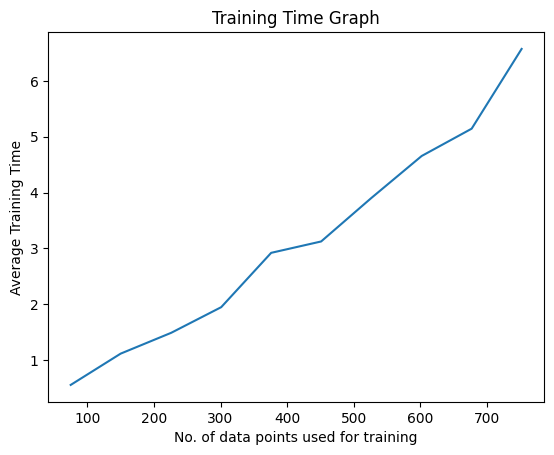

In [7]:
plt.plot(x, Time)
plt.ylabel('Average Training Time')
plt.xlabel('No. of data points used for training')
plt.title("Training Time Graph")
plt.show()

# Neural Networks

### Training on entire dataset

In [40]:
data = pd.read_csv(r"./data/facedata/facetrainwithfeatures.csv")
data_validation = pd.read_csv(r"./data/facedata/facevalidationwithfeatures.csv")
data_test = pd.read_csv(r"./data/facedata/facetestwithfeatures.csv")

In [41]:
labels = ['G0', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6','G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
    'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25','G26', 'G27', 'G28', 'G29', 'G30', 'G31', 'G32', 'G33', 'G34','G35', 'G36', 'G37', 'G38', 'G39', 'G40', 'G41', 'G42', 'G43',
    'G44', 'G45', 'G46', 'G47', 'G48', 'G49', 'G50', 'G51', 'G52','G53', 'G54', 'G55', 'G56', 'G57', 'G58', 'G59', 'G60', 'G61',
    'G62', 'G63', 'G64', 'G65', 'G66', 'G67', 'G68', 'G69', 'G70','G71', 'G72', 'G73', 'G74', 'G75', 'G76', 'G77', 'G78', 'G79',
    'G80', 'G81', 'G82', 'G83', 'G84', 'G85', 'G86', 'G87', 'G88','G89', 'G90', 'G91', 'G92', 'G93', 'G94', 'G95', 'G96', 'G97',
    'G98', 'G99']

In [42]:
Xtr = data[labels]
Ytr = data['Label']

Xtr_valid = data_validation[labels]
Ytr_valid = data_validation['Label']

In [43]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Ytr)
encoded_Y = encoder.transform(Ytr)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Ytr_valid)
encoded_Y = encoder.transform(Ytr)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_valid = np_utils.to_categorical(encoded_Y)

In [44]:
dnn_model = Sequential()

dnn_model.add(Dense(64,input_dim=100,activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(16, activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(8, activation='relu'))
dnn_model.add(BatchNormalization())

#Final dense layer on which softmax function is performed
dnn_model.add(Dense(2, activation='softmax'))


In [46]:
start_time = time.time()
dnn_model.compile(loss='binary_crossentropy',optimizer='adamax',metrics=['accuracy'])

In [47]:
history = dnn_model.fit(Xtr, dummy_y, validation_steps = (Xtr_valid,dummy_y_valid),epochs =100, batch_size = 32)

Epoch 1/100
15/15 [==============================] - 2s 2ms/step - loss: 0.7537 - accuracy: 0.5432
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6458 - accuracy: 0.6718
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6210 - accuracy: 0.6763
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5961 - accuracy: 0.7029
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.7273
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5507 - accuracy: 0.7672
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5293 - accuracy: 0.7871
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5312 - accuracy: 0.7849
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.7761
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5079 - accuracy: 0.7938
Epoch 11/

### Testing after training on entire dataset

In [48]:

Xtr_test = data_test[labels]
Ytr_test = data_test['Label']

# encode class values as integers
encoder_test = LabelEncoder()
encoder_test.fit(Ytr_test)
encoded_Y = encoder_test.transform(Ytr_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y)

In [49]:
predictions = dnn_model.predict(Xtr_test)

5/5 [==============================] - 0s 1ms/step


In [50]:
y_pred_test = []
for i in range(len(predictions)):
    y_pred_test.append(np.argmax(predictions[i]))

In [51]:
y_pred_test = pd.DataFrame(y_pred_test)
time_taken = time.time() - start_time

In [52]:
print(time_taken)

7.384415626525879


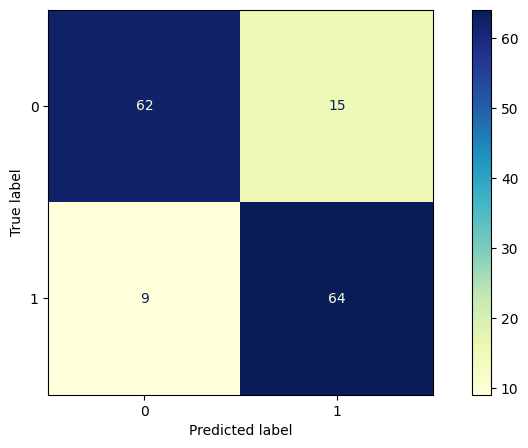

In [53]:
labels_1 = list(range(2))

cf_mtx = confusion_matrix(Ytr_test, y_pred_test)
img = ConfusionMatrixDisplay(cf_mtx, display_labels=labels_1)
fig, ax = plt.subplots(figsize=(10,5))
img.plot(ax=ax,cmap="YlGnBu")
plt.show()

In [54]:
print(classification_report(Ytr_test, y_pred_test, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        77
           1       0.81      0.88      0.84        73

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150



### Training on subdivisions of dataset

In [ ]:
mean_list = []
std_low = []
std_high = []
time_list = []
no_of_datapoints = []
data_split = data.append(data_validation)

for per in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    j = 0
    accuracy_list = []
    temp_times = []
    for j in range(5):
        
        sample_training_df  = data_split.sample(frac=per, random_state=j)
        sample_training_df  = sample_training_df.sort_values('Label')
        
        X_train = sample_training_df[labels]
        y_train = sample_training_df['Label']
        
        print(len(X_train))
        dnn_model = Sequential()
        dnn_model.add(Dense(64,input_dim=100,activation='relu'))
        dnn_model.add(BatchNormalization())
        dnn_model.add(Dense(32, activation='relu'))
        dnn_model.add(BatchNormalization())
        dnn_model.add(Dense(16, activation='relu'))
        dnn_model.add(BatchNormalization())

        #Final dense layer on which softmax function is performed
        dnn_model.add(Dense(2, activation='softmax'))

        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(y_train)
        encoded_Y = encoder.transform(y_train)
        # convert integers to dummy variables (i.e. one hot encoded)
        dummy_y = np_utils.to_categorical(encoded_Y)



        start_time = time.time()
        dnn_model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['accuracy'])
        history = dnn_model.fit(X_train, dummy_y,epochs =100)

        predictions = dnn_model.predict(Xtr_test)

        y_pred_test = []

        for i in range(len(predictions)):
            y_pred_test.append(np.argmax(predictions[i]))
        y_pred_test = pd.DataFrame(y_pred_test)
        a = accuracy_score(Ytr_test, y_pred_test)
        accuracy_list.append(a)
        temp_times.append(time.time() - start_time)
        j = j+1
    
    print(accuracy_list)
    print()
    no_of_datapoints.append(len(X_train))
    time_list.append(statistics.mean(temp_times))
    mean = statistics.mean(accuracy_list)
    mean_list.append(mean)
    std_dev = statistics.stdev(accuracy_list)
    std_low.append(mean-std_dev)
    std_high.append(mean+std_dev)


75
Epoch 1/100
3/3 [==============================] - 2s 5ms/step - loss: 0.8768 - accuracy: 0.5467
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.7067
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 0.6413 - accuracy: 0.6400
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 0.5462 - accuracy: 0.7200
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 0.5363 - accuracy: 0.7067
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 0.5035 - accuracy: 0.7467
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4211 - accuracy: 0.8133
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4561 - accuracy: 0.7867
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4508 - accuracy: 0.7867
Epoch 10/100
3/3 [==============================] - 0s 7ms/step - loss: 0.4253 - accuracy: 0.8133
Epoch 11/100
3/3 [========

In [ ]:
mean_list

[0.6799999999999999,
 0.7666666666666667,
 0.768,
 0.84,
 0.8666666666666667,
 0.8079999999999999,
 0.8826666666666667,
 0.868,
 0.86,
 0.8853333333333333]

In [ ]:
time_list

[3.2163437366485597,
 3.2013080596923826,
 3.976057291030884,
 4.481137609481811,
 4.609433889389038,
 5.46187686920166,
 5.571165132522583,
 6.087497758865356,
 6.62719235420227,
 7.201060819625854]

### Plotting Results

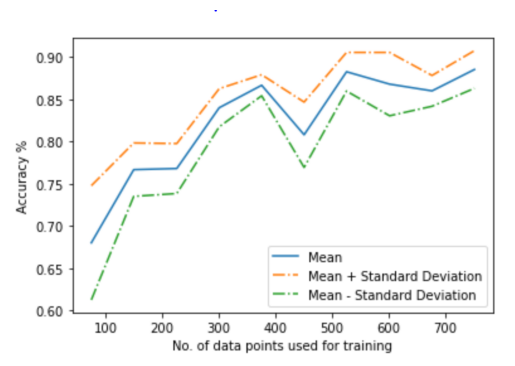

In [36]:
# Plot the graph of mean and standard deviation
plt.plot(no_of_datapoints, mean_list,label="Mean")
plt.plot(no_of_datapoints, std_high,'-.',label="Mean + Standard Deviation")
plt.plot(no_of_datapoints, std_low,'-.', label="Mean - Standard Deviation")
plt.xlabel("No. of data points used for training")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

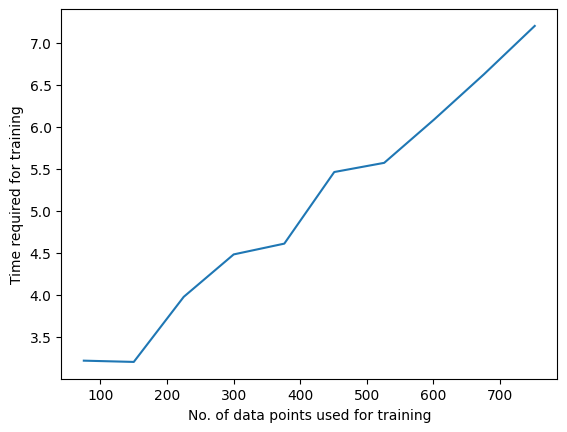

In [37]:
# Running time graph
plt.plot(no_of_datapoints, time_list)
plt.xlabel("No. of data points used for training")
plt.ylabel("Time required for training")
plt.show()

# Prediction for a single value from testing data 

In [55]:
random_state_value = 0

### Naive Bayes

Prediction: 1 
Actual Label: 1


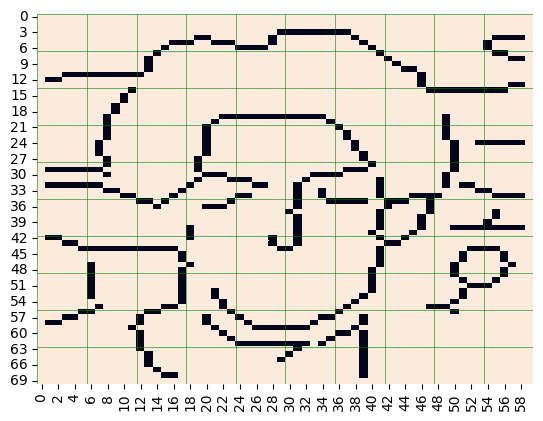

In [56]:
rand_test_df = testing_face_data_df.sample(random_state=random_state_value)
prediction, label = random_naive_face_test(rand_test_df, probability_of_face_features, probability_of_face_labels)
image = json.loads(rand_test_df.Image_data.to_list()[0])
seaborn.heatmap(image,cbar=False,cmap='rocket_r')
# To represent each subgroup
for i in range(0,70,7):
    plt.hlines(i,0,60,linewidth=0.4,color='g')
for j in range(0,60,6):
    plt.vlines(j,0,70,linewidth=0.4,color='g')
print("Prediction:", prediction, "\nActual Label:", label)

### Perceptron

In [60]:
weights_df = pd.read_csv(filepath+"/weights/faceweightsnew.csv", index_col=False)
weights_df['Weights'] = weights_df['Weights'].apply(json.loads)
weights = weights_df['Weights'].tolist()
weight = weights[0]

Prediction: 1 
Actual Label: 1


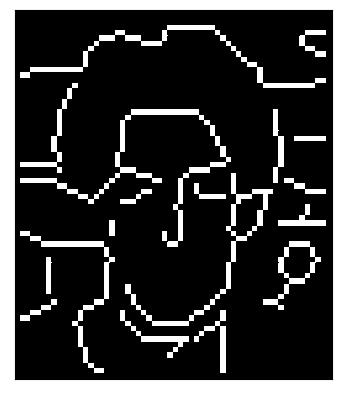

In [61]:
rand_test_df = test_df.sample(random_state=random_state_value)
prediction, label = random_perceptron_face_test(rand_test_df, weight)
image = rand_test_df.iloc[0][0]
print("Prediction:", prediction, "\nActual Label:", label)
display_image(image)

### Neural Network

1/1 [==============================] - 0s 18ms/step
Prediction: 1 
Actual Label: 1


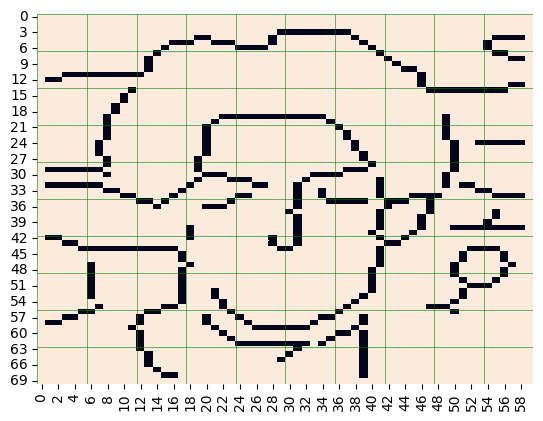

In [62]:
X_test_sample = data_test.sample(random_state=random_state_value)
label = X_test_sample.iloc[0][1]
image =  json.loads(X_test_sample.Image_data.to_list()[0])
prediction = np.argmax(dnn_model.predict(X_test_sample[labels]))
seaborn.heatmap(image,cbar=False,cmap='rocket_r')
# To represent each subgroup
for i in range(0,70,7):
    plt.hlines(i,0,60,linewidth=0.4,color='g')
for j in range(0,60,6):
    plt.vlines(j,0,70,linewidth=0.4,color='g')
print("Prediction:", prediction, "\nActual Label:", label)